In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

detanet_dir = "/content/drive/MyDrive/Colab Notebooks/DetaNet/code"

if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  import sys

  print('Running on CoLab, mounting google drive...')
  drive.mount('/content/drive')

  base_dir = "/content/drive/MyDrive/Colab Notebooks/CLAMS"
else:
  base_dir = os.getcwd()
  print('Not running on CoLab')

src_dir = os.path.join(base_dir, "src")

sys.path.append(base_dir)
sys.path.append(src_dir)
sys.path.append(detanet_dir)

Running on CoLab, mounting google drive...
Mounted at /content/drive


In [3]:
!pip install dataset
!pip install transformers
!pip install rdkit
!pip install tqdm
!pip install accelerate -U
!pip install e3nn
!pip install torch_geometric
!pip install torch-cluster==1.6.3 -f https://data.pyg.org/whl/torch-2.2.1+cu121.html
!pip install torch-scatter==2.1.2 -f https://data.pyg.org/whl/torch-2.2.1+cu121.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.30
    Uninstalling SQLAlchemy-2.0.30:
      Successfully uninstalled SQLAlchemy-2.0.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.52 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-many

In [4]:
import logging
import sys
import warnings
warnings.filterwarnings('ignore')

# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stdout)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(asctime)-15s %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler
logger.handlers = [handler]

# Read Data

In [5]:
import json

model_config = {
    'run4': {
        'vit': {
            'num_classes': 37,
            'hidden_size': 288,
            'num_hidden_layers': 9,
            'num_attention_heads': 9,
            'intermediate_size': 576,
            'num_channels': 1,
            'image_size': (66, 66),
            'patch_size': (6, 6),
            'hidden_dropout_prob': 0.1,
            'attention_probs_dropout_prob': 0.1,
            'batch_size': 300,
            'model_dir': os.path.join(base_dir, "models", "vit_models", 'run4')
        },
        'vit_training': {
            'num_epochs': 100,
            'lr': 1e-3,
            'step_size': 1,
            'gamma': 0.975,
            'early_stopping_epochs': 5,
        },
        'ic_training': {
            'batch_size': 300,
            'model_dir': os.path.join(base_dir, "models", "ic_models", 'run4'),
            'num_train_epochs': 120,
            'save_total_limit': 3,
            'max_length': 30,
            'num_beams': 5,
            'early_stopping_patience': 5,
            'canonicalize': True
        }
    },
    'run7': {
        'vit': {
            'num_classes': 18,
            'hidden_size': 288,
            'num_hidden_layers': 9,
            'num_attention_heads': 9,
            'intermediate_size': 576,
            'num_channels': 1,
            'image_size': (66, 66),
            'patch_size': (6, 6),
            'hidden_dropout_prob': 0.1,
            'attention_probs_dropout_prob': 0.1,
            'batch_size': 300,
            'model_dir': os.path.join(base_dir, "models", "vit_models", 'run7')
        },
        'vit_training': {
            'num_epochs': 100,
            'lr': 1e-3,
            'step_size': 1,
            'gamma': 0.975,
            'early_stopping_epochs': 5,
        },
        'ic_training': {
            'batch_size': 300,
            'model_dir': os.path.join(base_dir, "models", "ic_models", 'run7'),
            'num_train_epochs': 120,
            'save_total_limit': 3,
            'max_length': 30,
            'num_beams': 5,
            'early_stopping_patience': 5,
            'canonicalize': False
        },
    },
}

with open(os.path.join(base_dir, "configs/model_config.json"), "w") as f_hd:
    json.dump(model_config, f_hd)

In [6]:
from ir_dataset import IrDataset
from ir_smarts import SMARTS

run = 'run7'
config = model_config[run]

ds = IrDataset(data_list=None, data_path=os.path.join(base_dir, "data"), \
               use_transmittance=False, ir_only=False, \
               canonicalize=config['ic_training']['canonicalize'], \
               smarts=SMARTS)
ds.load()

2024-06-22 10:32:23,831 rdkit - INFO - Enabling RDKit 2023.09.6 jupyter extensions
2024-06-22 10:32:26,832 numexpr.utils - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-06-22 10:32:26,834 numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2024-06-22 10:32:27,132 root - INFO - Loading ir feature data from /content/drive/MyDrive/Colab Notebooks/CLAMS/data/ir_features.pth...
2024-06-22 10:34:28,209 root - INFO - Loading ir label data from /content/drive/MyDrive/Colab Notebooks/CLAMS/data/ir_labels.pth...
2024-06-22 10:34:38,731 root - INFO - Loading uv feature data from /content/drive/MyDrive/Colab Notebooks/CLAMS/data/uv_features.pth...
2024-06-22 10:34:50,053 root - INFO - Loading uv label data from /content/drive/MyDrive/Colab Notebooks/CLAMS/data/uv_labels.pth...
2024-06-22 10:34:58,873 root - INFO - Loading nmr feature data from /content/drive/MyDrive/Colab Notebooks/CLAMS/data/nmr_features.pth...
2024-06-22 10:35:14

In [7]:
len(ds)

127465

In [8]:
from rdkit import Chem

def determine_elements(smiles):
    # Parse the SMILES string and create a molecule object
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        print("Invalid SMILES string")
        return

    # Get the atomic symbols of the atoms in the molecule
    elements = set(atom.GetSymbol() for atom in mol.GetAtoms())
    mol_with_hydrogens = Chem.AddHs(mol)
    num_atoms = mol_with_hydrogens.GetNumAtoms()

    return elements, num_atoms, mol

all_elements = set()
num_atoms_max = 0
mol_largest = None

for item in ds:
    elements, num_atoms, mol = determine_elements(item[1])
    all_elements.update(elements)

    if num_atoms > num_atoms_max:
        num_atoms_max = num_atoms
        mol_largest = mol


logging.info("Max. number of atoms: %s, all_elements: %s", num_atoms_max, all_elements)

2024-06-22 10:37:18,237 root - INFO - Max. number of atoms: 29, all_elements: {'C', 'N', 'F', 'O'}


In [9]:
import torch

fgs = []
for item in ds:
    fgs.append(item[0].unsqueeze(0))

fg_labels = torch.cat(fgs, dim=0)
fg_labels.sum(dim=0)

tensor([118733,  16431,  15980,    273,   2057,  40664,  14261,  13991,   4458,
         56297,  38794,   8735,  15906,    601,  14261,   3102,   1514,    940])

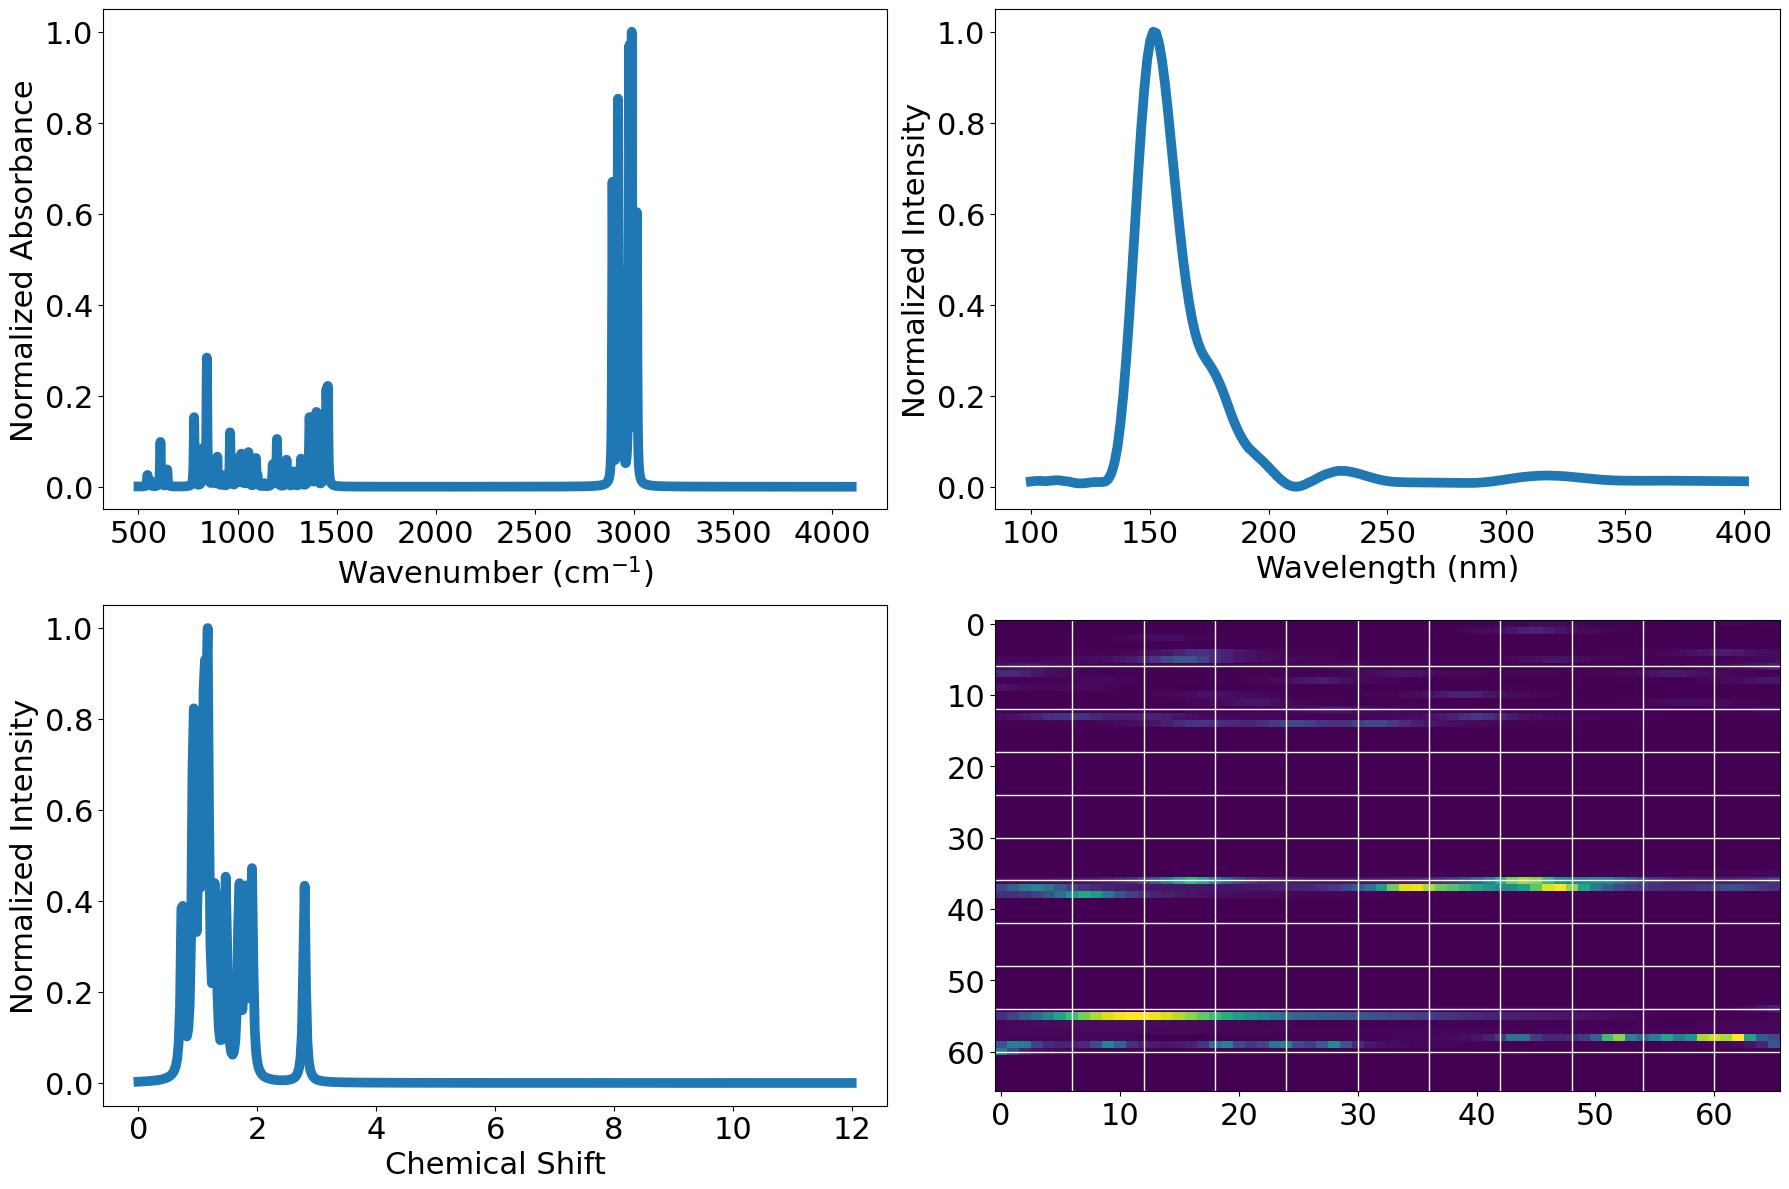

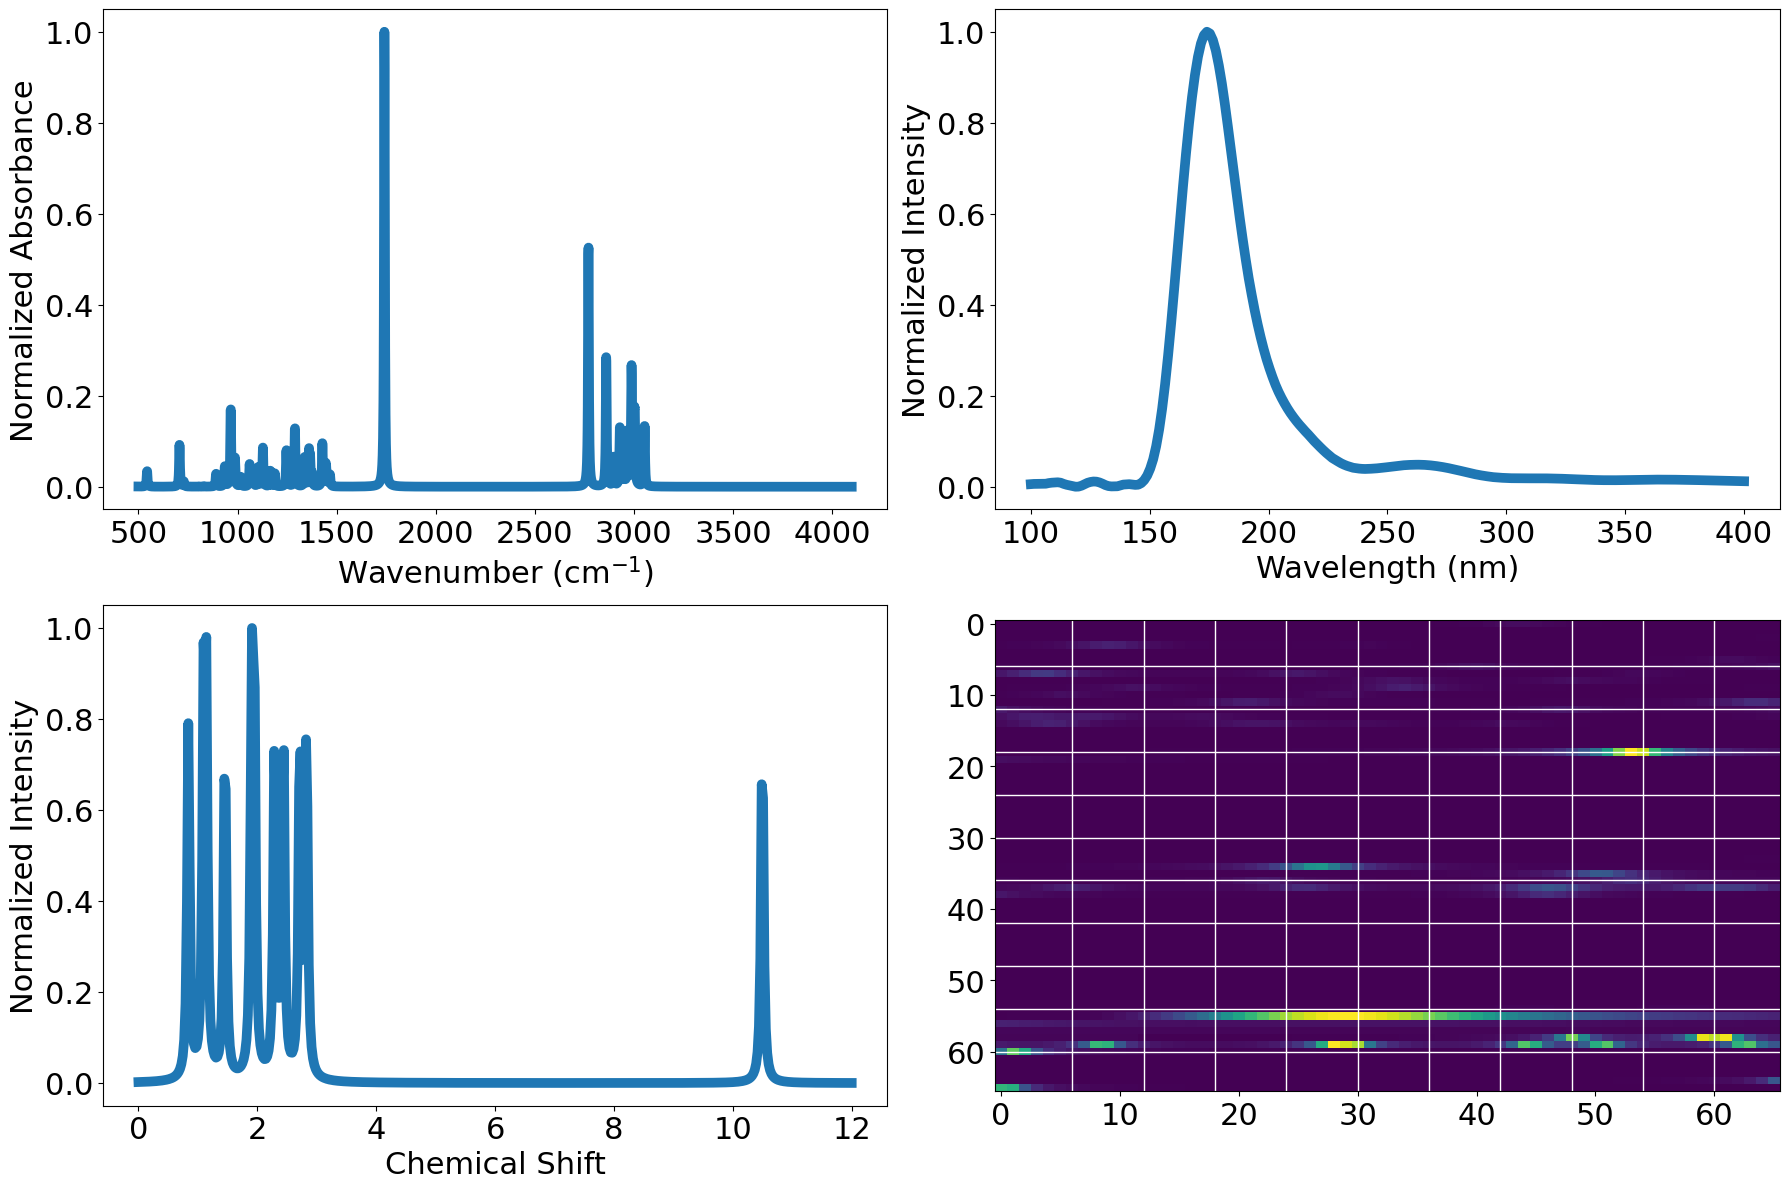

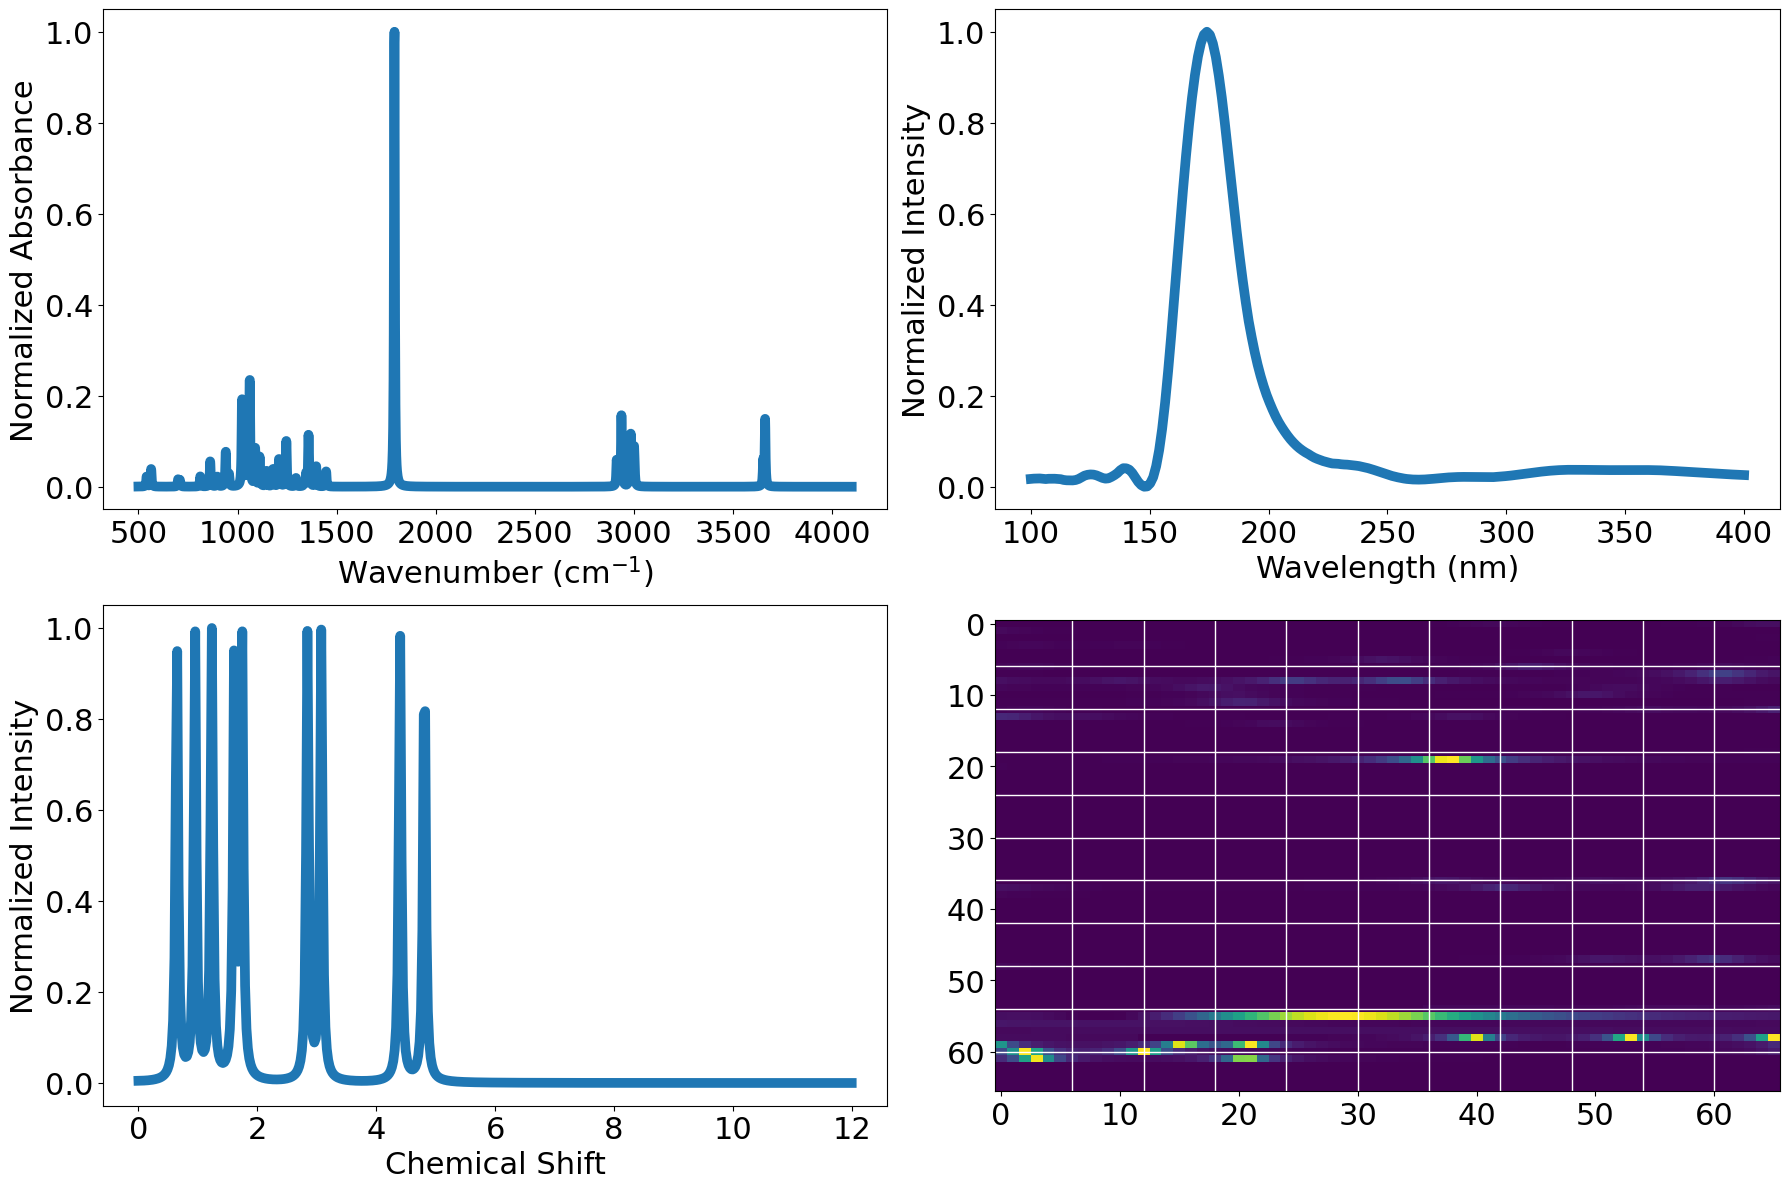

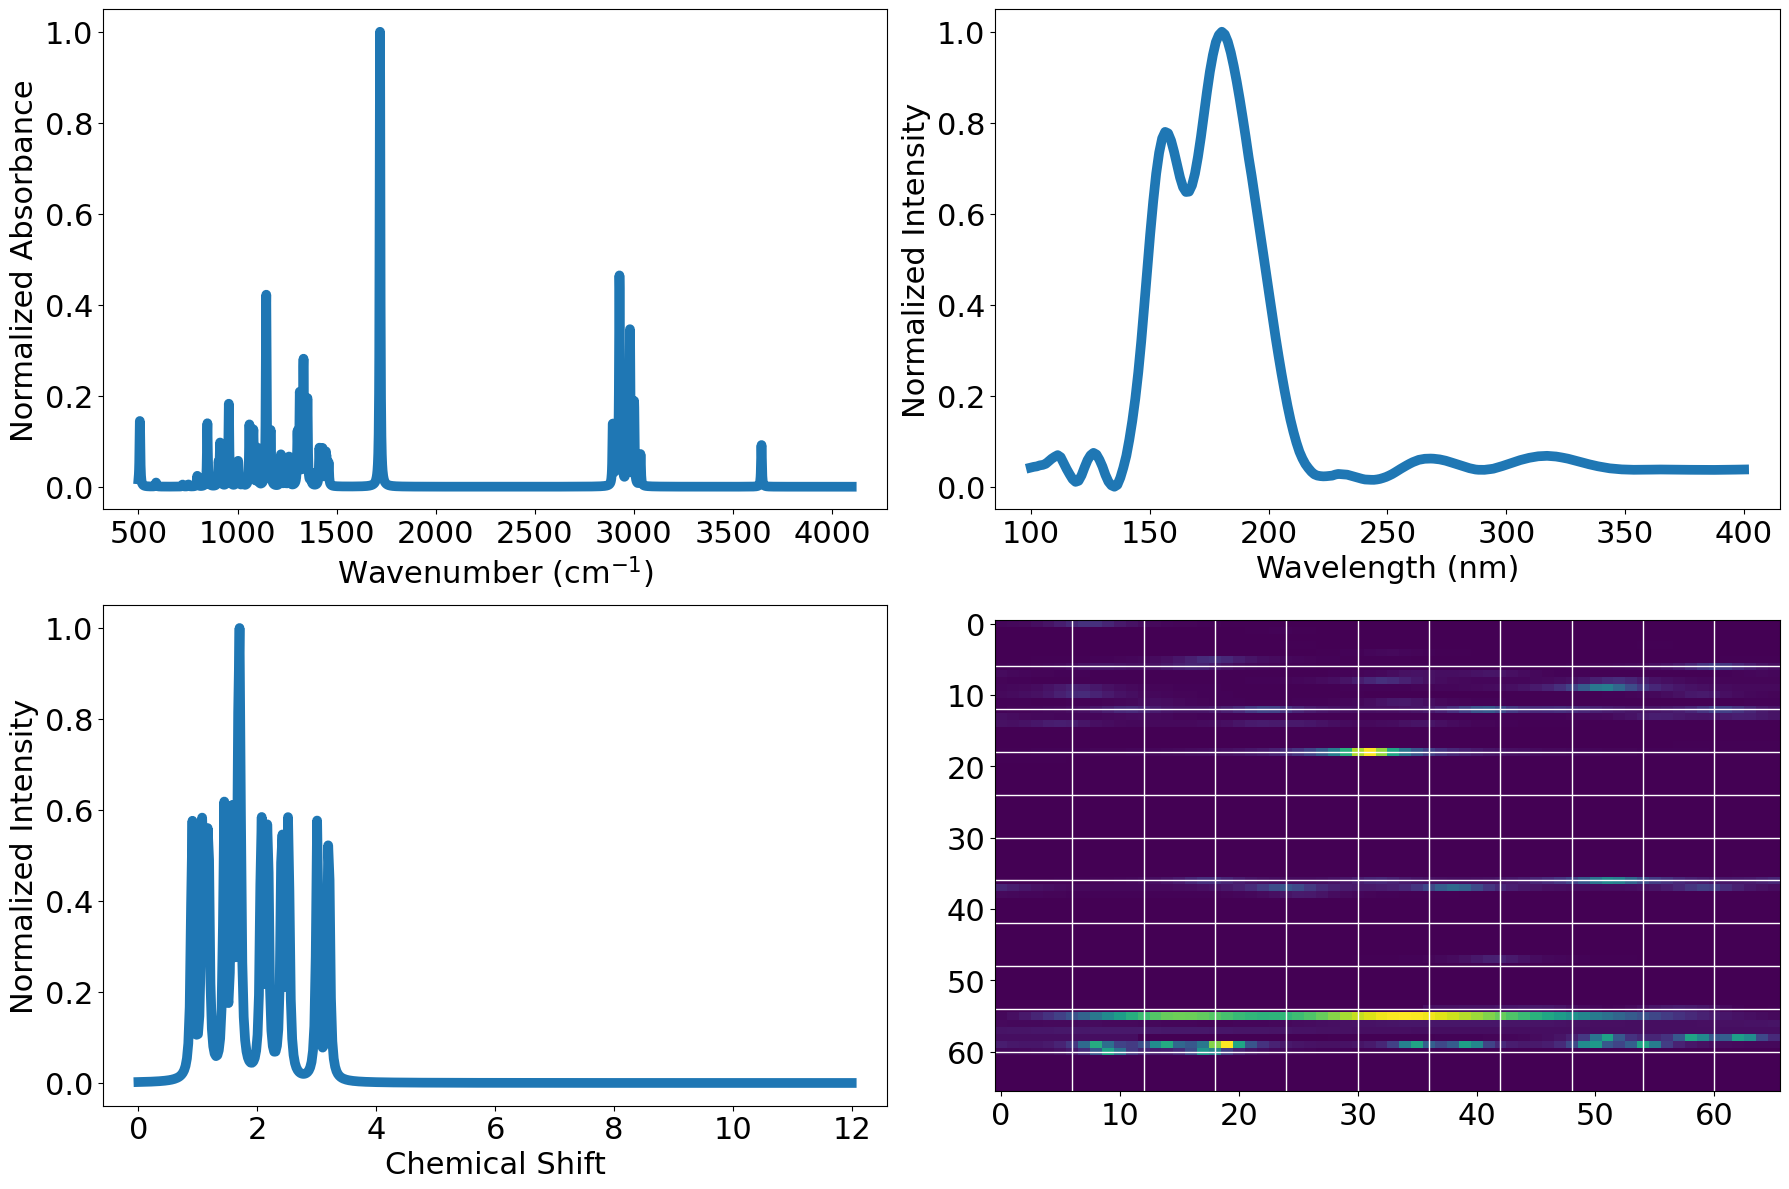

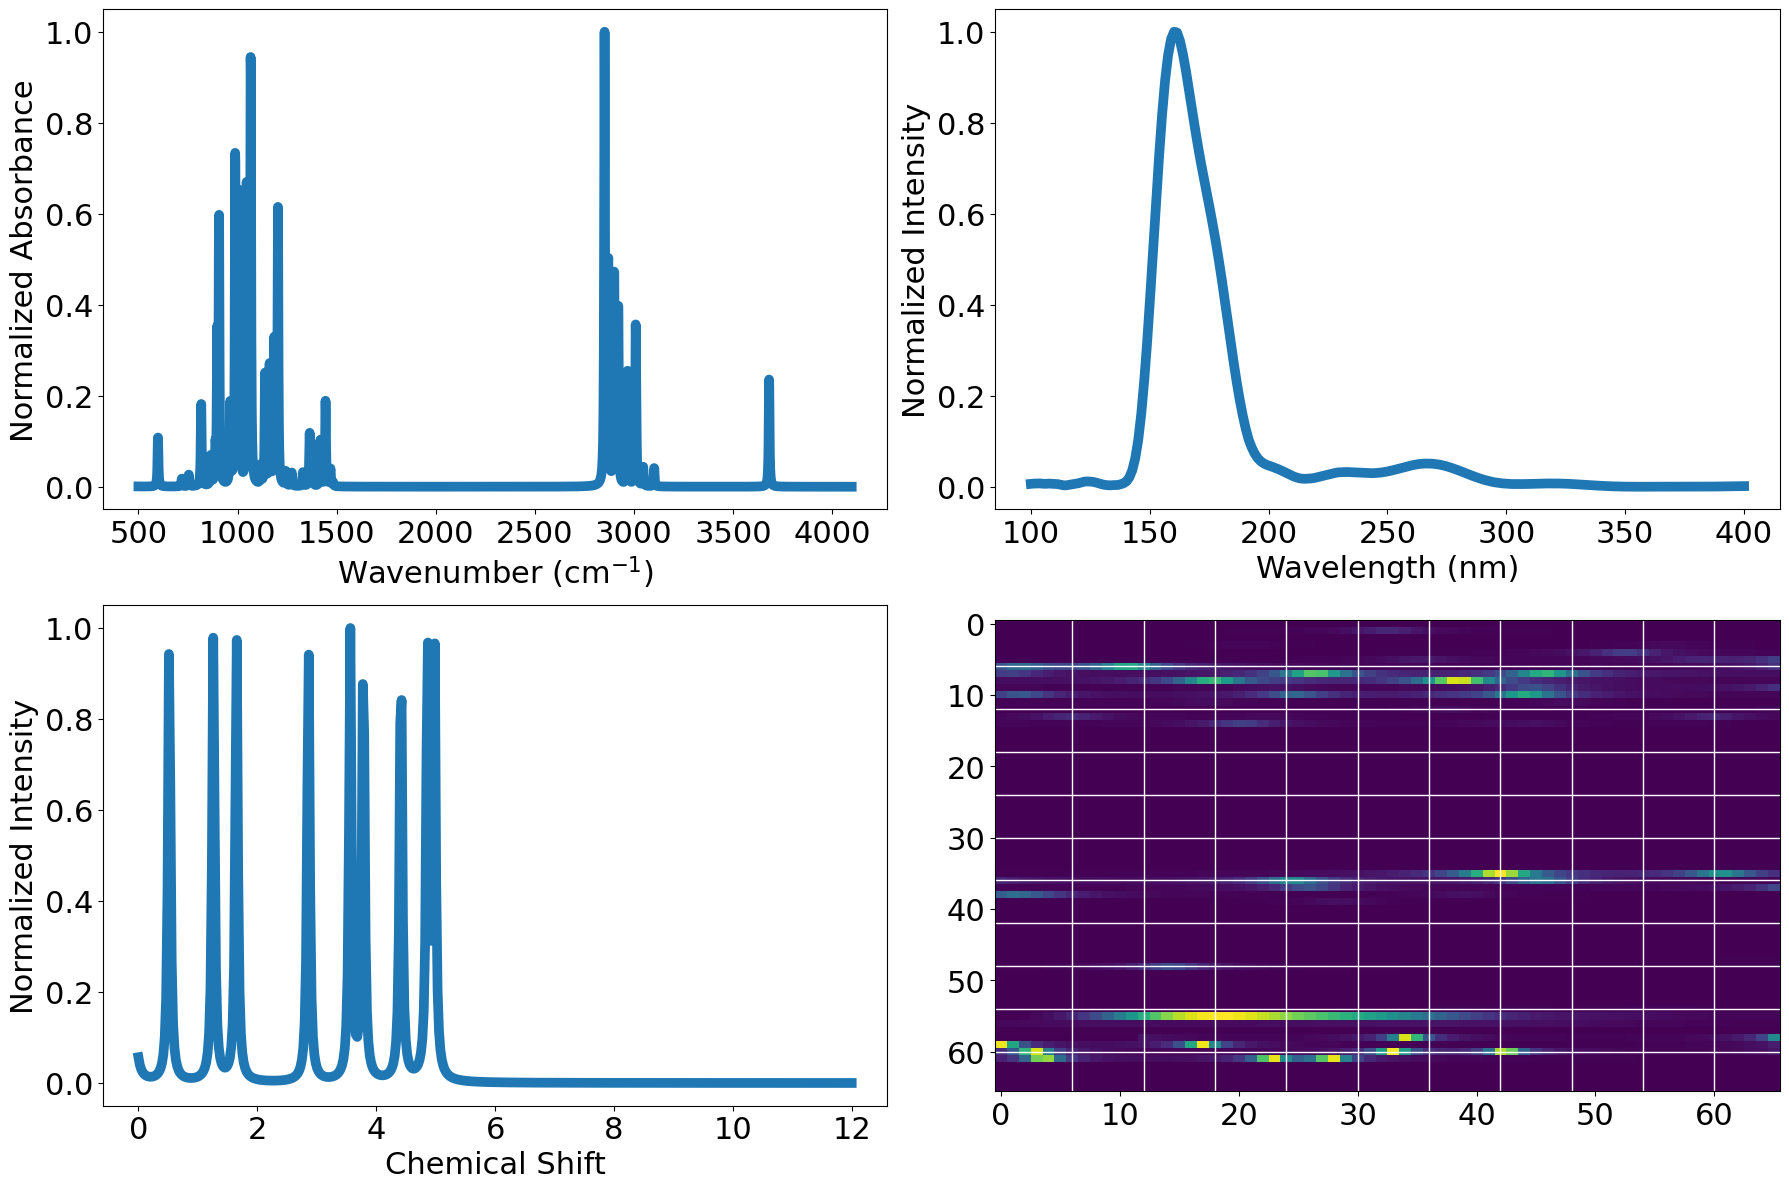

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# Define a function to plot the spectra
def plot_spectra(smiles, img, ir, uv, nmr):
    fig, ax = plt.subplots(2, 2, figsize=(18, 12))
    ax[0, 0].plot(torch.linspace(500, 4099, 3600), ir, linewidth=7)
    ax[0, 0].set_xlabel("Wavenumber (cm$^{-1}$)")
    ax[0, 0].set_ylabel("Normalized Absorbance")
    ax[0, 1].plot(torch.linspace(100, 400, 240), uv, linewidth=7)
    ax[0, 1].set_xlabel("Wavelength (nm)")
    ax[0, 1].set_ylabel("Normalized Intensity")
    ax[1, 0].plot(torch.linspace(0, 12, 516), nmr, linewidth=7)
    ax[1, 0].set_xlabel("Chemical Shift")
    ax[1, 0].set_ylabel("Normalized Intensity")
    ax[1, 1].imshow(img.squeeze(0), aspect=0.6)

    # Draw horizontal lines
    for i in range(1, 11):
        ax[1, 1].axhline(y=i * img.shape[1] // 11, color='white', linewidth=1)

    # Draw vertical lines
    for i in range(1, 11):
        ax[1, 1].axvline(x=i * img.shape[2] // 11, color='white', linewidth=1)

    for axis in ax.flatten():
        axis.xaxis.label.set_size(22)
        axis.yaxis.label.set_size(22)
        axis.tick_params(axis='both', which='major', labelsize=22)

    #fig.suptitle(f'{smiles}', fontsize=22)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'figs', f'Spectra_{smiles}.png'), dpi=300)
    plt.show()

# Randomly select 10 indices from the dataset
random_indices = random.sample(range(len(ds)), 5)

# Plot the spectra corresponding to the randomly selected indices
for idx in random_indices:
    label, smiles, img, ir, uv, nmr = ds[idx]
    plot_spectra(smiles, img, ir, uv, nmr)

    tol = 1e-15

    assert float(torch.max(torch.abs(ds[idx][2].view(-1)[(3600 + 240):] - ds.common_nmr[idx]))) < tol
    assert float(torch.max(torch.abs(ds[idx][2].view(-1)[3600: (3600 + 240)] - ds.common_uv[idx]))) < tol
    assert float(torch.max(torch.abs(ds[idx][2].view(-1)[:3600] - ds.common_ir[idx]))) < tol

# Prepare Data for Training

In [11]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split

batch_size = config['vit']['batch_size']

# Define the sizes of training, validation, and test sets
train_size = int(0.8 * len(ds))  # 80% of the data for training
val_size = int(0.1 * len(ds))    # 10% of the data for validation
test_size = len(ds) - train_size - val_size  # Remaining for testing

# Use random_split to split the dataset
torch.manual_seed(622)
train_dataset, val_dataset, test_dataset = random_split(ds, [train_size, val_size, test_size])

# You can optionally print the sizes of the splits
logging.info(f"Training set size: {len(train_dataset)}")
logging.info(f"Validation set size: {len(val_dataset)}")
logging.info(f"Testing set size: {len(test_dataset)}")

num_workers = 4
prefetch_factor = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, \
                          num_workers=num_workers, prefetch_factor=prefetch_factor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, \
                        num_workers=num_workers, prefetch_factor=prefetch_factor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

2024-06-22 10:37:32,729 root - INFO - Training set size: 101972
2024-06-22 10:37:32,730 root - INFO - Validation set size: 12746
2024-06-22 10:37:32,731 root - INFO - Testing set size: 12747


# Inspect the Vit Model Architecture

In [12]:
from encoder import Encoder
import torch

config = model_config[run]
vit_model = Encoder(config['vit'], torch.device("cpu"))
vit_model

Encoder(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(1, 288, kernel_size=(6, 6), stride=(6, 6))
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-8): 9 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=288, out_features=288, bias=True)
              (key): Linear(in_features=288, out_features=288, bias=True)
              (value): Linear(in_features=288, out_features=288, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=288, out_features=288, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=288, out_features

# Train the Vit + MLP for Classification of Functional Groups

In [13]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

logging.info("Device: %s", device)

2024-06-22 10:37:34,213 root - INFO - Device: cuda


In [14]:
model_dir = config['vit']['model_dir']
model_dir

'/content/drive/MyDrive/Colab Notebooks/CLAMS/models/vit_models/run7'

In [ ]:
from encoder import Encoder


config = model_config[run]
vit_model = Encoder(config['vit'], device)

model_dir = config['vit']['model_dir']

try:
    vit_model.load_weights(model_dir)
    logging.info("Model weights loaded from %s! Calculating metrics...", model_dir)
except Exception as ex:
    logging.error("Error loading model weights: %s", ex)

vit_model.train_model(**config['vit_training'],
                  model_dir=config['vit']['model_dir'],
                  train_loader=train_loader,
                  val_loader=val_loader,
                  device=device)

In [26]:
vit_model.vit.save_pretrained(config['vit']['model_dir'])

# Test the Trained Vit + MLP Classifier

In [16]:
from encoder import Encoder
from ir_smarts import SMARTS

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

logging.info("Device: %s", device)

config = model_config[run]
vit_model = Encoder(config['vit'])

vit_test_ret = vit_model.test_model(model_dir=config['vit']['model_dir'],
                    test_loader=test_loader, device=device,
                    labels=list(SMARTS.keys()))

2024-06-22 10:38:10,088 root - INFO - Device: cuda
2024-06-22 10:38:10,275 root - INFO - Model weights loaded from /content/drive/MyDrive/Colab Notebooks/CLAMS/models/vit_models/run7! Calculating metrics...


100%|██████████| 43/43 [00:02<00:00, 20.63it/s]


2024-06-22 10:38:12,512 root - INFO - Accuracy: 0.889935
2024-06-22 10:38:12,514 root - INFO - 
Classification Report:
              precision    recall  f1-score   support

      alkane       0.99      1.00      0.99     11846
      alkene       0.98      0.98      0.98      1635
      alkyne       0.98      0.98      0.98      1629
       arene       0.96      0.93      0.94        27
  haloalkane       0.94      0.76      0.84       217
     alcohol       1.00      0.99      0.99      4128
    aldehyde       0.99      1.00      1.00      1484
      ketone       0.97      0.93      0.95      1434
       ester       0.91      0.93      0.92       410
       ether       0.96      0.97      0.97      5589
       amine       0.94      0.92      0.93      3845
       amide       0.95      0.93      0.94       875
     nitrile       0.98      0.95      0.97      1541
       imide       0.88      0.80      0.84        56
       thial       0.99      1.00      1.00      1484
      phenol    

In [17]:
vit_test_ret['report_df'].to_hdf(
          os.path.join(config['vit']['model_dir'], "vit_test_results.h5"),
          key='report', mode='w')

In [18]:
with open(os.path.join(config['vit']['model_dir'], f"vit_test_results_{run}.json"), 'w') as fd:
    del vit_test_ret['report_df']
    json.dump(vit_test_ret, fd)

# Training the CLAMS Model

In [19]:
from ir_dataset import generate_ic_dataset
import json
from transformers import AutoTokenizer

# Pre-trained tokenizer
pretrained_decodert_dir = "seyonec/PubChem10M_SMILES_BPE_450k"
roberta_tokenizer = AutoTokenizer.from_pretrained(pretrained_decodert_dir)


ic_train_set = generate_ic_dataset(train_dataset, roberta_tokenizer,
                              max_length = config['ic_training']['max_length'])
ic_val_set = generate_ic_dataset(val_dataset, roberta_tokenizer,
                              max_length = config['ic_training']['max_length'])
ic_test_set = generate_ic_dataset(test_dataset, roberta_tokenizer,
                              max_length = config['ic_training']['max_length'])

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/515 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/165k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/101k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [20]:
config['ic_training']['batch_size']

300

In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

logging.info("Device: %s", device)

2024-06-22 10:38:56,232 root - INFO - Device: cuda


In [ ]:
from clams import create_clams_model, train_clams_model
from transformers import VisionEncoderDecoderModel
import torch

# If training a model from scratch, set `create_new` to True; otherwise, False
create_new = True

# set encoder decoder tying to True
if create_new:
    logging.info("Creating new model")
    model = create_clams_model(config['ic_training'], config['vit']['model_dir'],
                pretrained_decodert_dir, roberta_tokenizer, device=device)
else:
    logging.info("Loading existing model")
    model = VisionEncoderDecoderModel.from_pretrained(config['ic_training']['model_dir'])


train_clams_model(model, config['ic_training'], ic_train_set, ic_val_set)


In [ ]:
model.save_pretrained(config['ic_training']['model_dir'])

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 30, 'early_stopping': True, 'num_beams': 5}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


In [31]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(1, 288, kernel_size=(6, 6), stride=(6, 6))
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-8): 9 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=288, out_features=288, bias=True)
              (key): Linear(in_features=288, out_features=288, bias=True)
              (value): Linear(in_features=288, out_features=288, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=288, out_features=288, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_feat

In [32]:
from encoder import count_parameters

count_parameters(model)

104038624